## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)

        
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 68320
# species = 

endpointURL = "http://localhost:3030/REACTOME_CELEGANS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,62412
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,27586
2,http://www.biopax.org/release/biopax-level3.owl#Protein,14522
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,13336
4,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,12652
5,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,12652
6,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,11451
7,http://www.biopax.org/release/biopax-level3.owl#Evidence,4978
8,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,4951
9,http://www.biopax.org/release/biopax-level3.owl#RelationshipXref,4499


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,268


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4082


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,1672


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,2410


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,190


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,112


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,1560


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,1404


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    4350.000000
mean        2.415402
std         3.319929
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        64.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

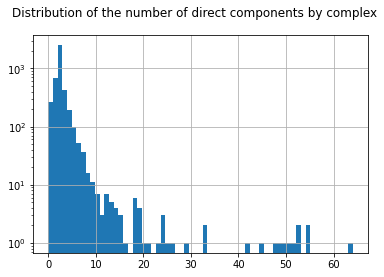

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

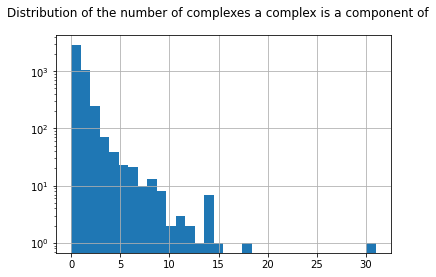

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,6222


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,2906


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,1868


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,2867


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,3087


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2,loc1


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

IndexError: index 0 is out of bounds for axis 0 with size 0

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [24]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [27]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.3794877529144287	http://www.reactome.org/biopax/81/68320#Complex4
1	0.909991979598999	http://www.reactome.org/biopax/81/68320#Complex6
2	1.3163704872131348	http://www.reactome.org/biopax/81/68320#Complex8
3	2.0353000164031982	http://www.reactome.org/biopax/81/68320#Complex9
4	2.5487570762634277	http://www.reactome.org/biopax/81/68320#Complex33
5	3.017056465148926	http://www.reactome.org/biopax/81/68320#Complex35
6	3.4564366340637207	http://www.reactome.org/biopax/81/68320#Complex36
7	3.946998357772827	http://www.reactome.org/biopax/81/68320#Complex37
8	4.438889741897583	http://www.reactome.org/biopax/81/68320#Complex98
9	4.794853448867798	http://www.reactome.org/biopax/81/68320#Complex109
10	5.099241495132446	http://www.reactome.org/biopax/81/68320#Complex111
11	5.418987512588501	http://www.reactome.org/biopax/81/68320#Complex116
12	6.288916826248169	http://www.reactome.org/biopax/81/68320#Complex117
13	6.490099668502808	http://www.reactome.org/biopax/81/68320#Complex144
14	6.63821

114	54.424236536026	http://www.reactome.org/biopax/81/68320#Complex801
115	54.7944221496582	http://www.reactome.org/biopax/81/68320#Complex807
116	55.307698011398315	http://www.reactome.org/biopax/81/68320#Complex815
117	55.69326114654541	http://www.reactome.org/biopax/81/68320#Complex836
118	56.12917113304138	http://www.reactome.org/biopax/81/68320#Complex838
119	56.480656147003174	http://www.reactome.org/biopax/81/68320#Complex840
120	56.74484467506409	http://www.reactome.org/biopax/81/68320#Complex841
121	57.23250770568848	http://www.reactome.org/biopax/81/68320#Complex842
122	57.45211410522461	http://www.reactome.org/biopax/81/68320#Complex844
123	57.951743602752686	http://www.reactome.org/biopax/81/68320#Complex846
124	58.73507380485535	http://www.reactome.org/biopax/81/68320#Complex847
125	59.39943790435791	http://www.reactome.org/biopax/81/68320#Complex850
126	59.69980049133301	http://www.reactome.org/biopax/81/68320#Complex857
127	60.71318483352661	http://www.reactome.org/biopa

226	106.28122758865356	http://www.reactome.org/biopax/81/68320#Complex1101
227	106.53662848472595	http://www.reactome.org/biopax/81/68320#Complex1102
228	106.82034730911255	http://www.reactome.org/biopax/81/68320#Complex1104
229	107.1849102973938	http://www.reactome.org/biopax/81/68320#Complex1105
230	107.58566641807556	http://www.reactome.org/biopax/81/68320#Complex1106
231	108.08366537094116	http://www.reactome.org/biopax/81/68320#Complex1109
232	108.66630697250366	http://www.reactome.org/biopax/81/68320#Complex1110
233	109.24881911277771	http://www.reactome.org/biopax/81/68320#Complex1111
234	110.00519299507141	http://www.reactome.org/biopax/81/68320#Complex1120
235	110.2574315071106	http://www.reactome.org/biopax/81/68320#Complex1123
236	110.48267006874084	http://www.reactome.org/biopax/81/68320#Complex1129
237	110.64938807487488	http://www.reactome.org/biopax/81/68320#Complex1130
238	110.81494331359863	http://www.reactome.org/biopax/81/68320#Complex1131
239	111.03900623321533	http

336	160.8655400276184	http://www.reactome.org/biopax/81/68320#Complex1423
337	162.86434078216553	http://www.reactome.org/biopax/81/68320#Complex1411
338	164.77697491645813	http://www.reactome.org/biopax/81/68320#Complex1413
339	165.82741498947144	http://www.reactome.org/biopax/81/68320#Complex1414
340	166.18123316764832	http://www.reactome.org/biopax/81/68320#Complex1430
341	168.39707255363464	http://www.reactome.org/biopax/81/68320#Complex1431
342	170.56093764305115	http://www.reactome.org/biopax/81/68320#Complex1432
343	172.54729795455933	http://www.reactome.org/biopax/81/68320#Complex1438
344	175.20416116714478	http://www.reactome.org/biopax/81/68320#Complex1440
345	178.01570200920105	http://www.reactome.org/biopax/81/68320#Complex1441
346	181.09469842910767	http://www.reactome.org/biopax/81/68320#Complex1448
347	181.41111850738525	http://www.reactome.org/biopax/81/68320#Complex1451
348	182.09603428840637	http://www.reactome.org/biopax/81/68320#Complex1449
349	182.30298972129822	htt

446	410.19364643096924	http://www.reactome.org/biopax/81/68320#Complex1652
447	426.52104091644287	http://www.reactome.org/biopax/81/68320#Complex1657
448	443.6207139492035	http://www.reactome.org/biopax/81/68320#Complex1658
449	460.70229411125183	http://www.reactome.org/biopax/81/68320#Complex1659
450	477.2264847755432	http://www.reactome.org/biopax/81/68320#Complex1660
451	493.56285643577576	http://www.reactome.org/biopax/81/68320#Complex1661
452	510.02659344673157	http://www.reactome.org/biopax/81/68320#Complex1665
453	510.82179260253906	http://www.reactome.org/biopax/81/68320#Complex1666
454	511.7378623485565	http://www.reactome.org/biopax/81/68320#Complex1667
455	512.7865347862244	http://www.reactome.org/biopax/81/68320#Complex1669
456	513.6689782142639	http://www.reactome.org/biopax/81/68320#Complex1670
457	514.8512165546417	http://www.reactome.org/biopax/81/68320#Complex1671
458	515.6514704227448	http://www.reactome.org/biopax/81/68320#Complex1673
459	515.9847214221954	http://www

557	619.9895279407501	http://www.reactome.org/biopax/81/68320#Complex1995
558	623.0439472198486	http://www.reactome.org/biopax/81/68320#Complex2001
559	623.3479080200195	http://www.reactome.org/biopax/81/68320#Complex1996
560	624.9087963104248	http://www.reactome.org/biopax/81/68320#Complex2005
561	631.0289032459259	http://www.reactome.org/biopax/81/68320#Complex2006
562	636.9979145526886	http://www.reactome.org/biopax/81/68320#Complex2007
563	639.6120619773865	http://www.reactome.org/biopax/81/68320#Complex2008
564	641.1596133708954	http://www.reactome.org/biopax/81/68320#Complex2015
565	641.4272367954254	http://www.reactome.org/biopax/81/68320#Complex2025
566	641.5779218673706	http://www.reactome.org/biopax/81/68320#Complex2030
567	641.8599834442139	http://www.reactome.org/biopax/81/68320#Complex2031
568	642.1599991321564	http://www.reactome.org/biopax/81/68320#Complex2032
569	642.5105011463165	http://www.reactome.org/biopax/81/68320#Complex2034
570	643.8069922924042	http://www.react

668	903.5662770271301	http://www.reactome.org/biopax/81/68320#Complex2234
669	903.8297476768494	http://www.reactome.org/biopax/81/68320#Complex2236
670	904.2042992115021	http://www.reactome.org/biopax/81/68320#Complex2237
671	904.4872660636902	http://www.reactome.org/biopax/81/68320#Complex2239
672	904.9519276618958	http://www.reactome.org/biopax/81/68320#Complex2240
673	905.3517217636108	http://www.reactome.org/biopax/81/68320#Complex2241
674	905.5527064800262	http://www.reactome.org/biopax/81/68320#Complex2242
675	905.7695789337158	http://www.reactome.org/biopax/81/68320#Complex2243
676	906.0700030326843	http://www.reactome.org/biopax/81/68320#Complex2244
677	906.6345131397247	http://www.reactome.org/biopax/81/68320#Complex2245
678	906.8547940254211	http://www.reactome.org/biopax/81/68320#Complex2249
679	907.2675285339355	http://www.reactome.org/biopax/81/68320#Complex2251
680	907.6503953933716	http://www.reactome.org/biopax/81/68320#Complex2253
681	907.952609539032	http://www.reacto

779	949.0066816806793	http://www.reactome.org/biopax/81/68320#Complex2491
780	949.398866891861	http://www.reactome.org/biopax/81/68320#Complex2492
781	949.8091418743134	http://www.reactome.org/biopax/81/68320#Complex2493
782	950.5775711536407	http://www.reactome.org/biopax/81/68320#Complex2494
783	950.8791053295135	http://www.reactome.org/biopax/81/68320#Complex2495
784	951.0837452411652	http://www.reactome.org/biopax/81/68320#Complex2497
785	951.361289024353	http://www.reactome.org/biopax/81/68320#Complex2498
786	951.6598331928253	http://www.reactome.org/biopax/81/68320#Complex2499
787	951.9745604991913	http://www.reactome.org/biopax/81/68320#Complex2500
788	952.3314731121063	http://www.reactome.org/biopax/81/68320#Complex2501
789	953.043032169342	http://www.reactome.org/biopax/81/68320#Complex2502
790	953.3945245742798	http://www.reactome.org/biopax/81/68320#Complex2503
791	953.7383735179901	http://www.reactome.org/biopax/81/68320#Complex2505
792	954.1379001140594	http://www.reactome

890	994.7886776924133	http://www.reactome.org/biopax/81/68320#Complex2734
891	995.2957656383514	http://www.reactome.org/biopax/81/68320#Complex2741
892	995.4976720809937	http://www.reactome.org/biopax/81/68320#Complex2744
893	995.6963610649109	http://www.reactome.org/biopax/81/68320#Complex2746
894	995.9316504001617	http://www.reactome.org/biopax/81/68320#Complex2747
895	996.2793192863464	http://www.reactome.org/biopax/81/68320#Complex2748
896	996.6444549560547	http://www.reactome.org/biopax/81/68320#Complex2749
897	996.7954823970795	http://www.reactome.org/biopax/81/68320#Complex2752
898	997.0952999591827	http://www.reactome.org/biopax/81/68320#Complex2753
899	997.3125414848328	http://www.reactome.org/biopax/81/68320#Complex2758
900	997.5282983779907	http://www.reactome.org/biopax/81/68320#Complex2760
901	997.8050727844238	http://www.reactome.org/biopax/81/68320#Complex2761
902	998.0943381786346	http://www.reactome.org/biopax/81/68320#Complex2765
903	998.3625423908234	http://www.react

1000	1044.59929728508	http://www.reactome.org/biopax/81/68320#Complex2956
1001	1044.753839969635	http://www.reactome.org/biopax/81/68320#Complex2958
1002	1045.4972457885742	http://www.reactome.org/biopax/81/68320#Complex2961
1003	1046.1964905261993	http://www.reactome.org/biopax/81/68320#Complex2962
1004	1046.812368631363	http://www.reactome.org/biopax/81/68320#Complex2966
1005	1046.9528713226318	http://www.reactome.org/biopax/81/68320#Complex2968
1006	1047.12442278862	http://www.reactome.org/biopax/81/68320#Complex2974
1007	1047.357441663742	http://www.reactome.org/biopax/81/68320#Complex2976
1008	1047.590868473053	http://www.reactome.org/biopax/81/68320#Complex2979
1009	1047.8146419525146	http://www.reactome.org/biopax/81/68320#Complex2983
1010	1048.0125415325165	http://www.reactome.org/biopax/81/68320#Complex2986
1011	1048.24431848526	http://www.reactome.org/biopax/81/68320#Complex2989
1012	1048.5784595012665	http://www.reactome.org/biopax/81/68320#Complex2997
1013	1048.803637266159

1109	1095.8644647598267	http://www.reactome.org/biopax/81/68320#Complex3248
1110	1096.5314733982086	http://www.reactome.org/biopax/81/68320#Complex3249
1111	1097.3808391094208	http://www.reactome.org/biopax/81/68320#Complex3255
1112	1097.797119140625	http://www.reactome.org/biopax/81/68320#Complex3260
1113	1098.9279823303223	http://www.reactome.org/biopax/81/68320#Complex3261
1114	1099.9937510490417	http://www.reactome.org/biopax/81/68320#Complex3262
1115	1100.1945686340332	http://www.reactome.org/biopax/81/68320#Complex3263
1116	1100.7491035461426	http://www.reactome.org/biopax/81/68320#Complex3266
1117	1101.4132792949677	http://www.reactome.org/biopax/81/68320#Complex3264
1118	1101.893161058426	http://www.reactome.org/biopax/81/68320#Complex3267
1119	1102.590173482895	http://www.reactome.org/biopax/81/68320#Complex3270
1120	1103.574584722519	http://www.reactome.org/biopax/81/68320#Complex3271
1121	1104.6082627773285	http://www.reactome.org/biopax/81/68320#Complex3274
1122	1105.106350

1218	1241.539321422577	http://www.reactome.org/biopax/81/68320#Complex3611
1219	1242.4538307189941	http://www.reactome.org/biopax/81/68320#Complex3612
1220	1245.6329400539398	http://www.reactome.org/biopax/81/68320#Complex3616
1221	1282.50537276268	http://www.reactome.org/biopax/81/68320#Complex3618
1222	1317.3282208442688	http://www.reactome.org/biopax/81/68320#Complex3619
1223	1356.4601945877075	http://www.reactome.org/biopax/81/68320#Complex3620
1224	1356.6855521202087	http://www.reactome.org/biopax/81/68320#Complex3621
1225	1395.669013261795	http://www.reactome.org/biopax/81/68320#Complex3622
1226	1395.8708448410034	http://www.reactome.org/biopax/81/68320#Complex3623
1227	1397.6244583129883	http://www.reactome.org/biopax/81/68320#Complex3627
1228	1403.1808397769928	http://www.reactome.org/biopax/81/68320#Complex3630
1229	1409.5902631282806	http://www.reactome.org/biopax/81/68320#Complex3624
1230	1410.471560716629	http://www.reactome.org/biopax/81/68320#Complex3625
1231	1411.0685424

1327	1642.7290172576904	http://www.reactome.org/biopax/81/68320#Complex3822
1328	1643.4671247005463	http://www.reactome.org/biopax/81/68320#Complex3826
1329	1644.1373798847198	http://www.reactome.org/biopax/81/68320#Complex3823
1330	1644.5270104408264	http://www.reactome.org/biopax/81/68320#Complex3824
1331	1644.6266720294952	http://www.reactome.org/biopax/81/68320#Complex3827
1332	1645.1918618679047	http://www.reactome.org/biopax/81/68320#Complex3828
1333	1645.7605991363525	http://www.reactome.org/biopax/81/68320#Complex3829
1334	1646.2411177158356	http://www.reactome.org/biopax/81/68320#Complex3830
1335	1646.3267443180084	http://www.reactome.org/biopax/81/68320#Complex3833
1336	1646.7457115650177	http://www.reactome.org/biopax/81/68320#Complex3834
1337	1647.0722422599792	http://www.reactome.org/biopax/81/68320#Complex3836
1338	1647.5072252750397	http://www.reactome.org/biopax/81/68320#Complex3837
1339	1649.1535844802856	http://www.reactome.org/biopax/81/68320#Complex3841
1340	1650.46

1436	1756.4795100688934	http://www.reactome.org/biopax/81/68320#Complex4146
1437	1756.8252046108246	http://www.reactome.org/biopax/81/68320#Complex4150
1438	1757.3497200012207	http://www.reactome.org/biopax/81/68320#Complex4148
1439	1757.5452647209167	http://www.reactome.org/biopax/81/68320#Complex4152
1440	1758.0681703090668	http://www.reactome.org/biopax/81/68320#Complex4155
1441	1758.4077937602997	http://www.reactome.org/biopax/81/68320#Complex4164
1442	1758.8502357006073	http://www.reactome.org/biopax/81/68320#Complex4165
1443	1759.4163026809692	http://www.reactome.org/biopax/81/68320#Complex4168
1444	1759.9964113235474	http://www.reactome.org/biopax/81/68320#Complex4166
1445	1760.4636905193329	http://www.reactome.org/biopax/81/68320#Complex4170
1446	1762.8391816616058	http://www.reactome.org/biopax/81/68320#Complex4171
1447	1763.1408574581146	http://www.reactome.org/biopax/81/68320#Complex4173
1448	1763.5829148292542	http://www.reactome.org/biopax/81/68320#Complex4175
1449	1764.31

1545	1913.9705255031586	http://www.reactome.org/biopax/81/68320#Complex4332
1546	1916.4878895282745	http://www.reactome.org/biopax/81/68320#Complex4333
1547	1922.5904004573822	http://www.reactome.org/biopax/81/68320#Complex4334
1548	1926.599692106247	http://www.reactome.org/biopax/81/68320#Complex4335
1549	1929.444298505783	http://www.reactome.org/biopax/81/68320#Complex4336
1550	1932.5054080486298	http://www.reactome.org/biopax/81/68320#Complex4337
1551	1939.2716038227081	http://www.reactome.org/biopax/81/68320#Complex4338
1552	1946.3611512184143	http://www.reactome.org/biopax/81/68320#Complex4339
1553	1954.048670053482	http://www.reactome.org/biopax/81/68320#Complex4341
1554	1963.1506910324097	http://www.reactome.org/biopax/81/68320#Complex4342
1555	1971.5072703361511	http://www.reactome.org/biopax/81/68320#Complex4343
1556	1979.5882709026337	http://www.reactome.org/biopax/81/68320#Complex4344
1557	1986.1674299240112	http://www.reactome.org/biopax/81/68320#Complex4346
1558	1986.93206

In [28]:
# concat files
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [29]:
# ..\..\Downloads\apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-complexes-invalid-fixed.ttl

In [30]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 426.6776692867279


In [31]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_CELEGANS/update
Duration: 405.6534903049469


In [32]:
# export file ttl :
# %%bash
# ${FUSEKI_HOME}/bin/s-get http://localhost:3030/reactome default > ./results/reactome-v81-48887-withoutComplex.ttl

### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-48887-invalid-complexes-fixed.ttl' 

    'reactome-v81-48887-withoutComplex.ttl' 

    'reactome-v81-48887-complexes-valid.ttl'